In [ ]:
import torch
from torch.utils.data import DataLoader

from polara import get_movielens_data

from neural_dice import SquaredActivation, ValueNetwork, NeuralDice
from policy import PopularRandomPolicy
from data import MovieLensBasicMDP, MovieLensSasrecMDP, transform_indices

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
RANDOM_SEED = 12345
DEVICE = torch.device('cuda:3')
BATCH_SIZE = 8
NUM_SAMPLES = 2048
NUM_ITER = 10000
EVAL_ITER = 100

ZETA_POS = False # squared output of zeta(s,a)                  (used in GenDICE, BestDice)
ZERO_REWARD = True  # if true than dont count for reward        (used in MQL, BestDICE)
NORM_REGULARIZER = 0.0 # use lambda or not                      (used in GenDICE, GradientDICE, BestDICE)
PRIMAL_REGULARIZER = 0.0 # alpha_Q                              (used in GenDICE, GradientDICE)
DUAL_REGULARIZER = 1.0 # alpha_zeta                             (used in DualDICE, BestDICE)

NU_LR = 0.0001
ZETA_LR = 0.0001
GAMMA = 0.99

In [3]:
data = get_movielens_data(local_file='./data/ml-1m.zip', include_time=True)
data, _ = transform_indices(data, 'userid', 'movieid')

sequences = data.sort_values(['userid', 'timestamp']).groupby('userid', sort=False)['movieid'].apply(list)

sequences

userid
0       [2969, 1178, 1574, 957, 2147, 1658, 3177, 2599...
1       [1108, 1120, 1127, 2512, 1201, 2735, 1135, 110...
2       [579, 2651, 3301, 1788, 1327, 1781, 1174, 1279...
3       [1120, 1025, 3235, 466, 3294, 253, 1106, 1108,...
4       [2512, 847, 858, 1158, 346, 2651, 1050, 2007, ...
                              ...                        
6035    [1574, 2235, 3206, 1703, 2183, 2298, 2621, 262...
6036    [1702, 3275, 672, 1175, 1848, 2932, 802, 548, ...
6037    [859, 3165, 1120, 1965, 346, 1288, 1007, 1066,...
6038    [275, 107, 1886, 869, 1139, 2809, 886, 2872, 2...
6039    [802, 579, 2191, 1781, 1839, 559, 1316, 207, 2...
Name: movieid, Length: 6040, dtype: object

In [4]:
NUM_ITEMS = data['movieid'].max() + 1
ITEMS_COUNT = data.movieid.value_counts().sort_index().values.tolist()

In [5]:
def custom_collate(data_list):
    first_state = []
    current_state = []
    current_action = []
    next_state = []
    rewards = []
    step_num = []
    has_next = []

    for fs, cs, ca, ns, rw, sn, hn in data_list:
        first_state.append(fs)
        current_state.append(cs)
        current_action.append(ca)
        next_state.append(ns)
        rewards.append(rw)
        step_num.append(sn)
        has_next.append(hn)

    return (
        torch.concat(first_state, dim=0),
        torch.concat(current_state, dim=0),
        torch.concat(current_action, dim=0),
        torch.concat(next_state, dim=0),
        torch.concat(rewards, dim=0),
        torch.concat(step_num, dim=0),
        torch.concat(has_next, dim=0)
    )

loader_generator = torch.Generator()
loader_generator.manual_seed(RANDOM_SEED)

# dataset = MovieLensBasicMDP(
#     num_items=NUM_ITEMS,
#     num_samples=NUM_SAMPLES,
#     user_sequences=sequences.values.tolist()
# )
dataset = MovieLensSasrecMDP(
    num_items=NUM_ITEMS,
    num_samples=NUM_SAMPLES,
    user_sequences=sequences.values.tolist(),
    sasrec_path=None,
    sasrec_device=DEVICE,
    embeddings_path='./models/sasrec_ml_states.pt'
)

loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4,
    pin_memory=True,
    collate_fn=custom_collate,
    persistent_workers=False,
    generator=loader_generator
)

100%|██████████| 6040/6040 [00:00<00:00, 177127.05it/s]


/home/blinkop/dice/data.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._states = torch.load(embeddings_path)


In [6]:
# policy = RandomPolicy(
#     num_actions=NUM_ITEMS,
#     device=DEVICE,
#     name='random',
#     seed=RANDOM_SEED
# )

policy = PopularRandomPolicy(
    items_count=ITEMS_COUNT,
    device=DEVICE,
    name='pop_random',
    seed=RANDOM_SEED
)

In [7]:
nu = ValueNetwork(
    num_layers=2,
    state_dim=dataset.state_dim,
    action_dim=NUM_ITEMS,
    hidden_dim=64,
    output_activation=None,
    seed=RANDOM_SEED
)
nu = nu.to(DEVICE)

zeta = ValueNetwork(
    num_layers=2,
    state_dim=dataset.state_dim,
    action_dim=NUM_ITEMS,
    hidden_dim=64,
    output_activation=SquaredActivation if ZETA_POS else None,
    seed=RANDOM_SEED+1
)
zeta = zeta.to(DEVICE)

nu_optimizer = torch.optim.Adam(list(nu.parameters()), lr=NU_LR)
zeta_optimizer = torch.optim.Adam(list(zeta.parameters()), lr=ZETA_LR)

dice = NeuralDice(
    nu_network=nu,
    zeta_network=zeta,
    nu_lr=NU_LR,
    zeta_lr=ZETA_LR,
    lambda_lr=NU_LR,
    num_actions=NUM_ITEMS,
    gamma=GAMMA,
    zero_reward=ZERO_REWARD,
    f_exponent=1.5,
    primal_form=False,
    num_action_samples=None, # number of action samples used in Q expectation
    primal_regularizer=PRIMAL_REGULARIZER,
    dual_regularizer=DUAL_REGULARIZER,
    norm_regularizer=NORM_REGULARIZER,
    nu_regularizer=0.0, # nu network regularizer
    zeta_regularizer=0.0, # zeta network regularizer
    weight_by_gamma=False, # weight loss by gamma**step_num
    device=DEVICE
)

In [8]:
def estimate_policy(data: MovieLensBasicMDP):
    values = []
    for batch in data.iterate_dataset(batch_size=100):
        batch = [b.to(DEVICE) for b in batch]
        states, actions, rewards = batch

        values.append(
            dice.estimate_average_reward(
                states=states,
                actions=actions,
                rewards=rewards
            )
        )

    return sum(values) / data.num_users

In [9]:
losses = []
values = []

i = 0
for batch in loader:
    if i >= NUM_ITER:
        break

    batch = [b.to(DEVICE) for b in batch]

    loss = dice.train_batch(batch=batch, policy=policy)
    losses.append(loss)

    if i % EVAL_ITER  == 0 or i == (NUM_ITER - 1):
        value = estimate_policy(data=dataset)
        print(f'Value on iteration {i}: {value}')
        values.append(value)

    i += 1

Value on iteration 0: -6.812923264464006
Value on iteration 100: -5.244906028641376
Value on iteration 200: 3.791961985638994
Value on iteration 300: -2.3331344626597224
Value on iteration 400: -0.6477104288655401
Value on iteration 500: -0.7557789552932149
Value on iteration 600: -0.5811290170781511
Value on iteration 700: -0.3884401153495523
Value on iteration 800: -0.4013880699891474
Value on iteration 900: -0.04772280452723633
Value on iteration 1000: 0.9082372889854013
Value on iteration 1100: -0.6522168646363036
Value on iteration 1200: 5.640569462040007
Value on iteration 1300: -3.827747371560888
Value on iteration 1400: 2.0781358470560503
Value on iteration 1500: 3.5588223025942876
Value on iteration 1600: 0.7264725965133171
Value on iteration 1700: -0.2665341587996246
Value on iteration 1800: -2.9853738212970313
Value on iteration 1900: -1.3777379315642528
Value on iteration 2000: 4.9972140057863585
Value on iteration 2100: -4.270321758214804
Value on iteration 2200: 2.4493564

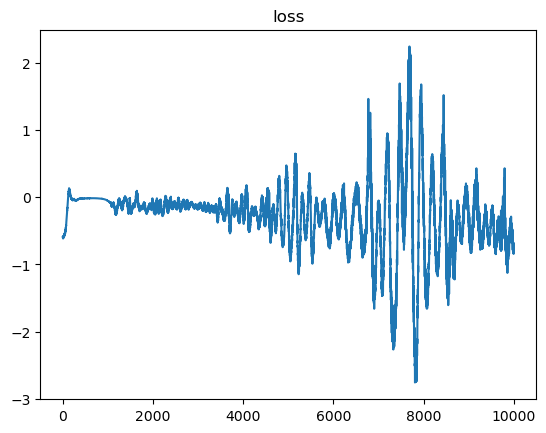

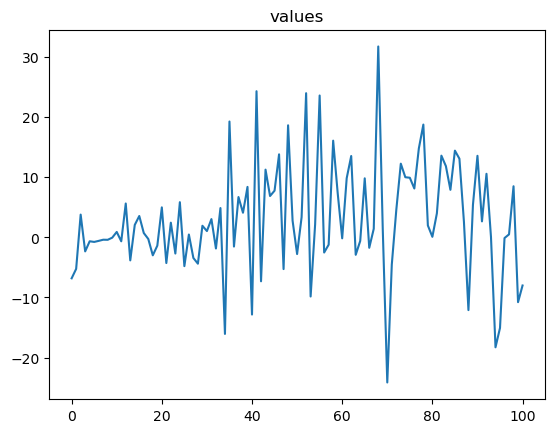

In [10]:
plt.plot(losses)
plt.title('loss')
plt.show()

plt.plot(values)
plt.title('values')
plt.show()